# Fibermagic Tutorial - Getting Started

Here, we will walk through the basic steps of using Fibermagic to analyze fiber photometry data.

We will learn how to read in a single recording from a single mouse with a single fiber and two signals: GRAB-rDA in the red spectrum to measure dopamine, and GRAB-ACh in the green spectrum to measure acetylcholine. Specifically, we will learn:
* how to read in photometry data from the Neurophotometrics system
* how to merge it with event data, for example food pellet dispenses.
* how to detrend the photometry data and calculate z-scores
* how to compute peri-event time courses


We need only two files:
* the photometry data file which contains the data recorded by the Neurophotometrics system
* the events file which contains the events that occurred during the recording (sometimes this is actually part of the photometry file)

## Reading in the photometry data

We need the filepath to the photometry data. In our case, we have a separate file for the datetimestamps. Alternatively, we can write the datetimestamps into the photometry file directly when using Bonsai. Datetimestamps are typically in the format `YYYY-MM-DD HH:MM:SS.000` but we can also use simpler timestamps, for example the number of seconds since the boot of the NPM system.

Let's start by downloading an example dataset (33 MB). This will take a few seconds. For your own data, replace the paths with your own data.


In [1]:
import pandas as pd
import sys
sys.path.append(r'C:\Users\Georg\Git\fibermagic')
%load_ext autoreload
%autoreload 2
import fibermagic

fibermagic.download('tutorial-1')
photometry_path = r'fibermagic_tutorial_1\photometry.csv'
timestamps_path = r'fibermagic_tutorial_1\time.csv'
events_path = r'fibermagic_tutorial_1\events.csv'

We also need to specify what region measures what. These are the regions that we defined in the Bonsai pipeline. For each region, we also need to specify the wavelength of the light that was used to stimulate the fiber. This is 560nm for the red signal and 470nm for the green signal.

# <img src="_static/data-organization/regions_of_interest.PNG" width="400">


In [10]:
region_to_mouse = {'mouse': ['B3637', 'B3637'], 'region': ['Region6R', 'Region7G'], 'wave_len': [560, 470]}

Now, we can read in the photometry data using the `read_npm` function from the `fibermagic` package. We need to pass the photometry path and the timestamps path. We also need to pass the region_to_mouse dictionary.

In [11]:
df = fibermagic.read_npm(photometry_path, extra_timestamps_path=timestamps_path, region_to_mouse=region_to_mouse)
df

,datetimestamp,red_signal,green_signal,red_reference,green_reference,mouse,Time (sec)
1,2022-08-25 18:17:18.501862400,0.003922,0.003923,0.004414,0.003922,B3637,0.064781
2,2022-08-25 18:17:18.541670400,0.004173,0.003922,0.004426,0.003922,B3637,0.104589
3,2022-08-25 18:17:18.581312000,0.004163,0.003922,0.004445,0.003922,B3637,0.144230
4,2022-08-25 18:17:18.621440000,0.004162,0.003922,0.004417,0.003922,B3637,0.184358
5,2022-08-25 18:17:18.661440000,0.004226,0.003922,0.004449,0.003922,B3637,0.224358
...,...,...,...,...,...,...,...
110731,2022-08-25 19:31:07.778009600,0.003995,0.003922,0.004213,0.003922,B3637,4429.340928
110732,2022-08-25 19:31:07.818304000,0.003984,0.003922,0.004192,0.003922,B3637,4429.381222
110733,2022-08-25 19:31:07.856960000,0.003982,0.003922,0.004212,0.003922,B3637,4429.419878
110734,2022-08-25 19:31:07.897395200,0.003976,0.003922,0.004232,0.003922,B3637,4429.460314


# Reading in and merging events data

Now, we can read in the log file that stores the events, in our case events from the conditioning chamber. For example, we collected events for each lever press and each food pellet dispense ("FD")

In this case, we have the following columns:
* `datetimestamp`: the timestamp of the event
* `event`: the event that occurred
* `mouse`: the mouse that performed the event
* additional columns that we won't need for now


We can now use the `merge_events` function to merge the events with the photometry data. We need to pass the photometry data, the events, the event column, the datetime column, the mouse column, the start event and the stop event.

This function does a few things:
* it merges the events with the photometry data
* if we have specific events that indicate when the session starts and stops, we can use those to crop the data


In [12]:
df = fibermagic.merge_events(df, events_path=events_path, event_col='event', datetime_col='datetimestamp', by='mouse', start_event='video_start', stop_event='video_stop')
df

,datetimestamp,red_signal,green_signal,red_reference,green_reference,mouse,Time (sec),event
0,2022-08-25 18:32:58.038297600,0.028955,0.005737,0.004763,0.004306,B3637,0.000000,video_start
1,2022-08-25 18:32:58.079321600,0.028914,0.005834,0.004802,0.004324,B3637,0.041024,NaN
2,2022-08-25 18:32:58.118131200,0.028923,0.005930,0.004755,0.004322,B3637,0.079834,NaN
3,2022-08-25 18:32:58.158502400,0.028874,0.005828,0.004800,0.004314,B3637,0.120205,NaN
4,2022-08-25 18:32:58.199411200,0.028850,0.005743,0.004798,0.004320,B3637,0.161114,NaN
...,...,...,...,...,...,...,...,...
65900,2022-08-25 19:16:51.203020800,0.018271,0.005487,0.004464,0.004190,B3637,2633.164723,NaN
65901,2022-08-25 19:16:51.243251200,0.018298,0.005499,0.004459,0.004188,B3637,2633.204954,NaN
65902,2022-08-25 19:16:51.284057600,0.018354,0.005534,0.004482,0.004148,B3637,2633.245760,NaN
65903,2022-08-25 19:16:51.323609600,0.018505,0.005530,0.004498,0.004183,B3637,2633.285312,LL


# Detrending and z-scoring the photometry data

We can use the `demodulate` function to detrend and z-score the photometry data. We need to pass the following arguments:
* `data`: the photometry data
* `timestamps`: the column name of the timestamps of the photometry data
* `signal`: the column name of the signal that we want to detrend and z-score
* `standardize`: whether to z-score the data (if False, we will get the dFF instead)


This function is a very powerful one that we can use to do much more! However, for now, we can stick with the default settings. Per default, `demodulate` will estimate the baseline using the `airPLS` alrogithm and subtract and divide by it to get the dFF. Then, it will z-score the data.




In [5]:
df['DA zdFF'] = fibermagic.demodulate(data=df, timestamps='Time (sec)', signal='red_signal', standardize=True)
df['ACh zdFF'] = fibermagic.demodulate(data=df, timestamps='Time (sec)', signal='green_signal', standardize=True)
df

,datetimestamp,red_signal,green_signal,red_reference,green_reference,mouse_x,Time (sec),mouse_y,event,DA zdFF,ACh zdFF
0,2022-08-25 18:32:58.038297600,0.028955,0.005737,0.004763,0.004306,B3637,0.000000,B3637,video_start,-1.145354,0.681895
1,2022-08-25 18:32:58.079321600,0.028914,0.005834,0.004802,0.004324,B3637,0.041024,NaN,NaN,-1.237454,1.776616
2,2022-08-25 18:32:58.118131200,0.028923,0.005930,0.004755,0.004322,B3637,0.079834,NaN,NaN,-1.218074,2.850487
3,2022-08-25 18:32:58.158502400,0.028874,0.005828,0.004800,0.004314,B3637,0.120205,NaN,NaN,-1.329573,1.703694
4,2022-08-25 18:32:58.199411200,0.028850,0.005743,0.004798,0.004320,B3637,0.161114,NaN,NaN,-1.385336,0.744563
...,...,...,...,...,...,...,...,...,...,...,...
65900,2022-08-25 19:16:51.203020800,0.018271,0.005487,0.004464,0.004190,B3637,2633.164723,NaN,NaN,-0.280072,0.194956
65901,2022-08-25 19:16:51.243251200,0.018298,0.005499,0.004459,0.004188,B3637,2633.204954,NaN,NaN,-0.182833,0.335582
65902,2022-08-25 19:16:51.284057600,0.018354,0.005534,0.004482,0.004148,B3637,2633.245760,NaN,NaN,0.023347,0.746700
65903,2022-08-25 19:16:51.323609600,0.018505,0.005530,0.004498,0.004183,B3637,2633.285312,B3637,LL,0.579699,0.703392


Now, let's plot the data with the events

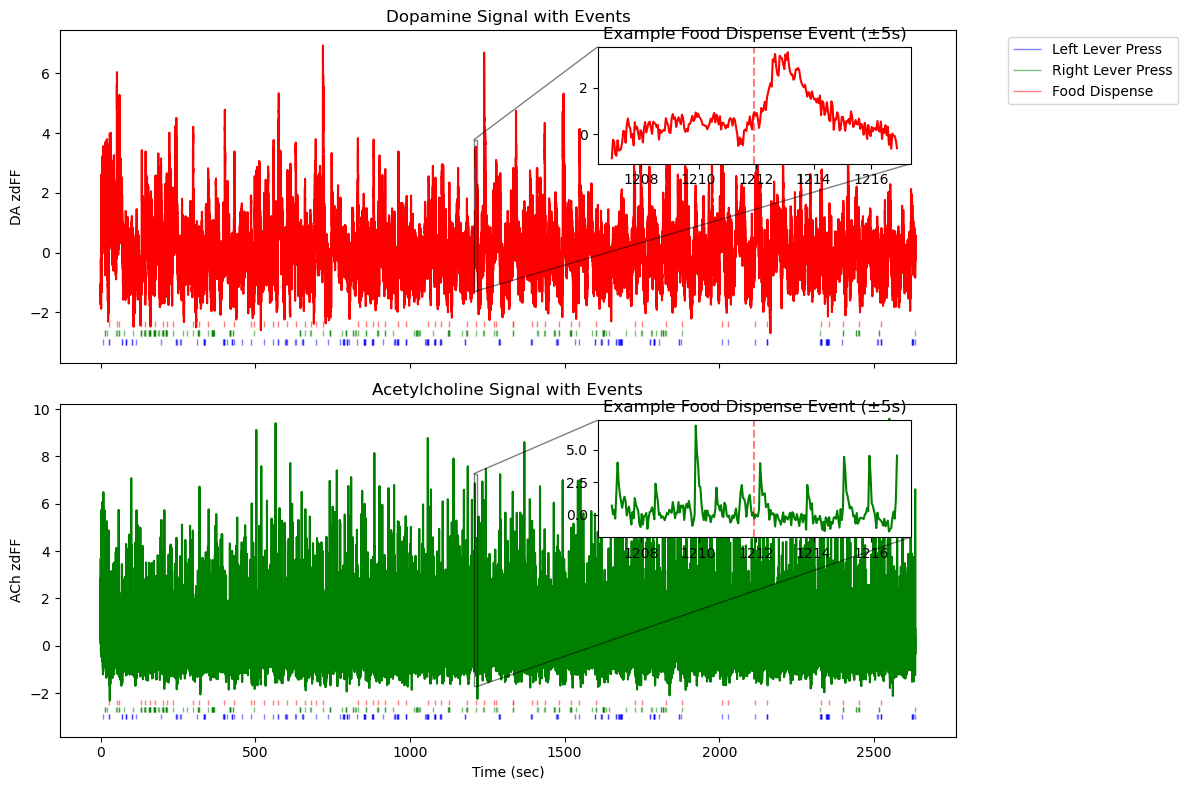

In [6]:
import matplotlib.pyplot as plt

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Get events data for LL, RL and FD only
events_df = df[df['event'].isin(['LL', 'RL', 'FD'])][['Time (sec)', 'event']]

# Plot DA signal
ax1.plot(df['Time (sec)'], df['DA zdFF'], color='red')
for i, event_type in enumerate(['LL', 'RL', 'FD']):
    event_times = events_df[events_df['event'] == event_type]['Time (sec)']
    color = 'blue' if event_type == 'LL' else ('green' if event_type == 'RL' else 'red')
    label = 'Left Lever Press' if event_type == 'LL' else ('Right Lever Press' if event_type == 'RL' else 'Food Dispense')
    ax1.eventplot(event_times, colors=color, 
                 linelengths=0.2, linewidths=1, alpha=0.5, lineoffsets=-3+i*0.3,
                 label=label)
ax1.set_ylabel('DA zdFF')
ax1.set_title('Dopamine Signal with Events')

# Plot ACh signal  
ax2.plot(df['Time (sec)'], df['ACh zdFF'], color='green')
for i, event_type in enumerate(['LL', 'RL', 'FD']):
    event_times = events_df[events_df['event'] == event_type]['Time (sec)']
    color = 'blue' if event_type == 'LL' else ('green' if event_type == 'RL' else 'red')
    ax2.eventplot(event_times, colors=color,
                 linelengths=0.2, linewidths=1, alpha=0.5, lineoffsets=-3+i*0.3)
ax2.set_xlabel('Time (sec)')
ax2.set_ylabel('ACh zdFF')
ax2.set_title('Acetylcholine Signal with Events')

# Add single legend for events
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Create inset around 3rd FD event
fd_events = events_df[events_df['event'] == 'FD']
third_fd_time = fd_events.iloc[38]['Time (sec)']

# Create inset axes for both plots
axins1 = ax1.inset_axes([0.6, 0.6, 0.35, 0.35])
axins2 = ax2.inset_axes([0.6, 0.6, 0.35, 0.35])

# Plot data in insets
window = 5  # seconds before/after event
mask = (df['Time (sec)'] >= third_fd_time - window) & (df['Time (sec)'] <= third_fd_time + window)

# DA inset
axins1.plot(df.loc[mask, 'Time (sec)'], df.loc[mask, 'DA zdFF'], color='red')
axins1.axvline(x=third_fd_time, color='red', linestyle='--', alpha=0.5)
axins1.set_title('Example Food Dispense Event (±5s)')

# ACh inset
axins2.plot(df.loc[mask, 'Time (sec)'], df.loc[mask, 'ACh zdFF'], color='green')
axins2.axvline(x=third_fd_time, color='red', linestyle='--', alpha=0.5)
axins2.set_title('Example Food Dispense Event (±5s)')

# Draw box showing inset region
x1, x2 = third_fd_time - window, third_fd_time + window
y1, y2 = df.loc[mask, 'DA zdFF'].min(), df.loc[mask, 'DA zdFF'].max()
ax1.indicate_inset_zoom(axins1, edgecolor="black")

y1, y2 = df.loc[mask, 'ACh zdFF'].min(), df.loc[mask, 'ACh zdFF'].max()
ax2.indicate_inset_zoom(axins2, edgecolor="black")

# Adjust layout
plt.tight_layout()
plt.show()



# Computing peri-event time courses

Now, we can compute the peri-event time courses for the DA and ACh signals. Peri events are traces of the signal around the event of interest. We basically look at every event and chop out a few seconds before and after the event. Then, we average all these traces together to see if there is a change in the signal around the event of interest. We can use the `perievents` function to compute the peri-event time courses for the DA and ACh signals. We need to pass the following arguments:
* `data`: the photometry data
* `time_column`: the column name of the timestamps of the photometry data
* `event_column`: the column name of the events that we want to compute the peri-event time courses for
* `data_columns`: the column names of the signals that we want to compute the peri-event time courses for
* `window`: the window size before and after the event
* `only_average`: whether to only average the traces or to return the traces themselves



In [7]:
peri = fibermagic.perievents(df, time_column='Time (sec)', event_column='event', data_columns=['DA zdFF', 'ACh zdFF'], window=5, only_average=False)
peri

,Event,Trial,Relative Time,Time (sec),DA zdFF,ACh zdFF
0,LL,0,-5.000000,3.119974,-0.773501,2.416289
1,LL,0,-4.966667,3.119974,-0.773501,2.416289
2,LL,0,-4.933333,3.160026,-0.361726,1.488420
3,LL,0,-4.900000,3.160026,-0.361726,1.488420
4,LL,0,-4.866667,3.201152,-0.168028,5.471312
...,...,...,...,...,...,...
128695,P_LL=0.06_RL=0.2,3,4.833333,2348.040166,-0.753032,0.296151
128696,P_LL=0.06_RL=0.2,3,4.866667,2348.079936,0.132521,0.957514
128697,P_LL=0.06_RL=0.2,3,4.900000,2348.079936,0.132521,0.957514
128698,P_LL=0.06_RL=0.2,3,4.933333,2348.119821,0.152253,0.838241


We can use `seaborn` to plot the peri-event time courses. It will plot the mean of the traces and the standard error of the mean.

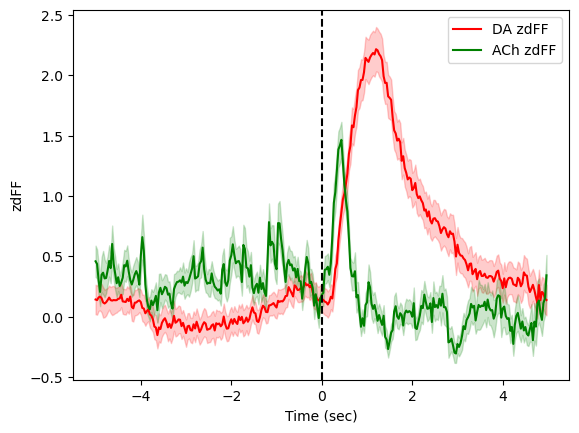

In [8]:
import seaborn as sns

sns.lineplot(data=peri[peri['Event'] == 'FD'], x='Relative Time', y='DA zdFF', color='red', label='DA zdFF', errorbar='se')
sns.lineplot(data=peri[peri['Event'] == 'FD'], x='Relative Time', y='ACh zdFF', color='green', label='ACh zdFF', errorbar='se')
plt.xlabel('Time (sec)')
plt.ylabel('zdFF')
plt.axvline(x=0, color='black', linestyle='--')
